**Librerías requeridas**

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [2]:
!pip install google-cloud-storage -q

In [3]:
from google.cloud import storage

# Ruta al archivo de credenciales de la service account
SERVICE_ACCOUNT_JSON = "../../credentials_gcp.json"

# Nombres de los buckets
BUCKETS = {
    "bronze": "proyecto-universitaria-bronze",
    "silver": "proyecto-universitaria-silver",
    "gold": "proyecto-universitaria-gold",
}

# Crear cliente de GCS
client = storage.Client.from_service_account_json(SERVICE_ACCOUNT_JSON)

for level, bucket_name in BUCKETS.items():
    print(f"\n=== {level.upper()} BUCKET: {bucket_name} ===")
    bucket = client.get_bucket(bucket_name)
    
    # Listar objetos
    print("Objetos en el bucket:")
    blobs = list(bucket.list_blobs())
    if not blobs:
        print("  (Vacío)")
    else:
        for blob in blobs:
            print(f"  {blob.name}")
    
    # Intentar subir un archivo de prueba
    try:
        test_blob = bucket.blob(f"test_{level}.txt")
        test_blob.upload_from_string(f"Hola desde {level.capitalize()} bucket!")
        print(f"Archivo de prueba subido correctamente a {bucket_name}")
    except Exception as e:
        print(f"No se pudo subir archivo a {bucket_name}: {e}")


/home/neo/.envs/IronHack/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.12) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)



=== BRONZE BUCKET: proyecto-universitaria-bronze ===
Objetos en el bucket:
  datasets/students_dropout_academic_success.csv
  test_bronze.txt
Archivo de prueba subido correctamente a proyecto-universitaria-bronze

=== SILVER BUCKET: proyecto-universitaria-silver ===
Objetos en el bucket:
  test_silver.txt
Archivo de prueba subido correctamente a proyecto-universitaria-silver

=== GOLD BUCKET: proyecto-universitaria-gold ===
Objetos en el bucket:
  project_student.ipynb
  test_gold.txt
Archivo de prueba subido correctamente a proyecto-universitaria-gold


In [4]:
# Configuración estética
sns.set(style="whitegrid", palette="viridis")
plt.rcParams["figure.figsize"] = (10,6)

**Carga de Datos**

In [5]:
# Cargar los datos 
from google.cloud import storage
import pandas as pd
from io import StringIO

# Ruta al archivo de credenciales de la service account
SERVICE_ACCOUNT_JSON = "../../credentials_gcp.json"

# Nombre del bucket y del archivo que quieres leer
bucket_name = "proyecto-universitaria-bronze"
file_name = "datasets/students_dropout_academic_success.csv"  # Cambia al nombre de tu archivo


# Crear cliente de GCS
client = storage.Client.from_service_account_json(SERVICE_ACCOUNT_JSON)
bucket = client.get_bucket(bucket_name)

# Descargar el contenido del archivo a memoria
blob = bucket.blob(file_name)
data = blob.download_as_text()  # Descarga como string

# Convertir a DataFrame usando pandas
df = pd.read_csv(StringIO(data))  # si es CSV
df_bucket = df
# df = pd.DataFrame([line.split(",") for line in data.splitlines()])  # si es texto plano separado por comas

print("Contenido del DataFrame:")
print(df.head())

Contenido del DataFrame:
   Marital Status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                       1   
4                           0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2            

**Exploración Inicial**

In [6]:
# Exploración inicial
print("Dimensiones:", df.shape)
print("\nTipos de datos:")
print(df.dtypes)
print("\nValores nulos:")
print(df.isnull().sum())

df.head()

Dimensiones: (4424, 37)

Tipos de datos:
Marital Status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date        

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


**Limpieza y Preprocesamiento de Datos**

In [7]:
# Eliminar duplicados (si los hay)
n_dup = df.duplicated().sum()
print(f"Duplicados detectados: {n_dup}")
df = df.drop_duplicates().reset_index(drop=True)

Duplicados detectados: 0


**Mapeo de la Target**

In [8]:
df["target"].value_counts()

target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

**Convertir target a numérico**

In [9]:
# Convertir target a numérico
df["target"] = df["target"].map({"Dropout": 0, "Graduate": 1, "Enrolled": 2} )

## EDA
---

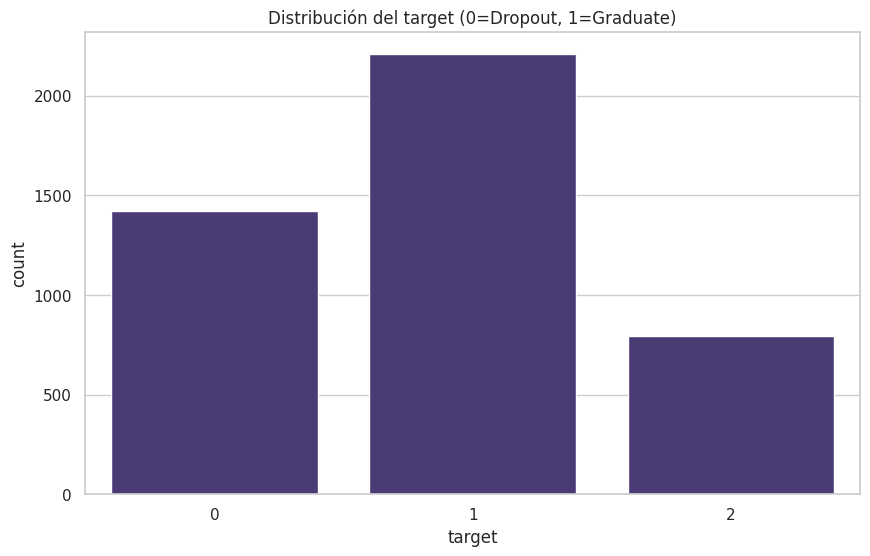

In [10]:
# --- Distribución del target
sns.countplot(x="target", data=df)
plt.title("Distribución del target (0=Dropout, 1=Graduate)")
plt.show()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,target
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969,0.858273
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935,0.693326
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000,1.000000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000,1.000000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000,2.000000


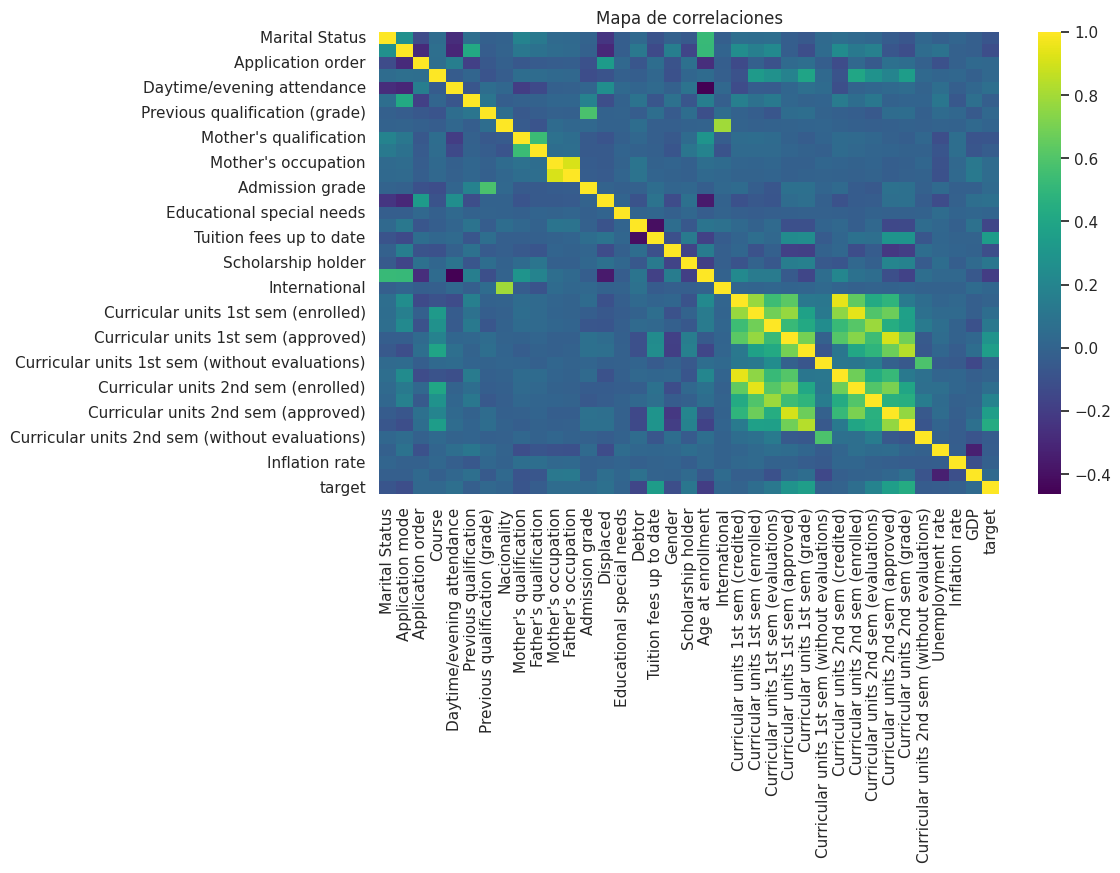

In [11]:
# --- Estadísticas descriptivas
display(df.describe())

# --- Correlación de variables numéricas
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="viridis", annot=False)
plt.title("Mapa de correlaciones")
plt.show()

## Modelo 01
---

In [12]:
# =====================================
# Preparación para el modelo
# =====================================
X = df.drop(columns=["target"])
y = df["target"]

# Escalar los datos numéricos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [41]:
print(X.columns)
print(y.name)

Index(['Marital Status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

Accuracy: 0.7590361445783133

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      0.79      0.79       441
           1       0.77      0.93      0.84       642
           2       0.54      0.27      0.36       245

    accuracy                           0.76      1328
   macro avg       0.70      0.66      0.66      1328
weighted avg       0.74      0.76      0.74      1328



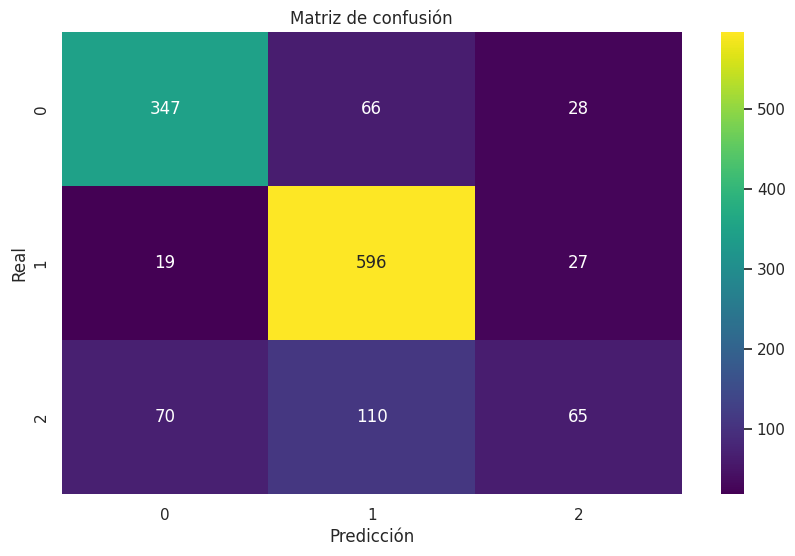

In [13]:
# =====================================
# Modelo supervisado (Random Forest)
# =====================================
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# =====================================
# Evaluación del modelo
# =====================================
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


                                  Variable  Importancia
30     Curricular units 2nd sem (approved)     0.146484
31        Curricular units 2nd sem (grade)     0.114345
24     Curricular units 1st sem (approved)     0.086299
25        Curricular units 1st sem (grade)     0.059766
12                         Admission grade     0.042776
29  Curricular units 2nd sem (evaluations)     0.041324
19                       Age at enrollment     0.038539
23  Curricular units 1st sem (evaluations)     0.038401
6           Previous qualification (grade)     0.036732
16                 Tuition fees up to date     0.036150


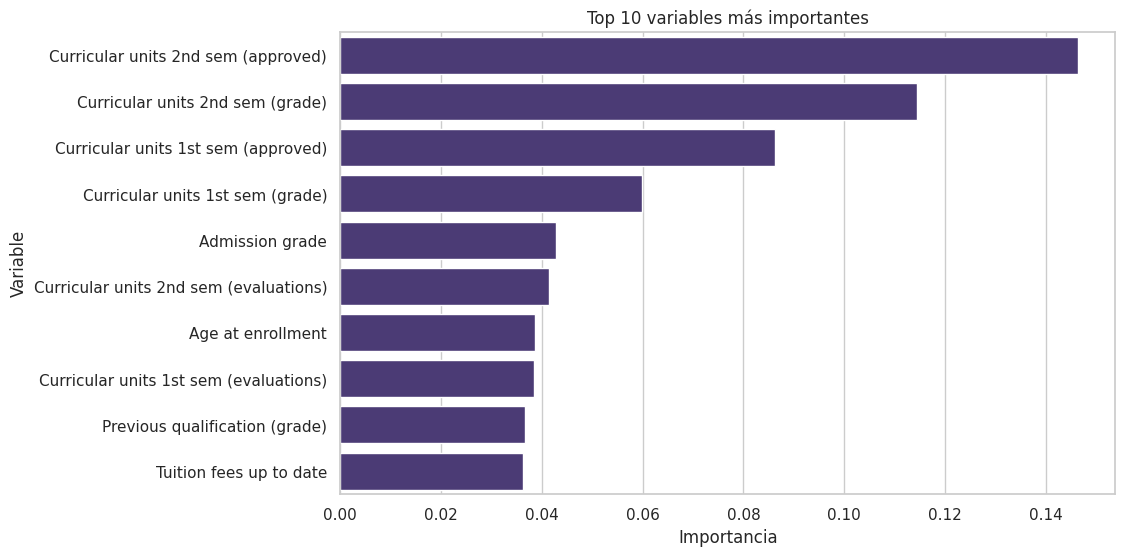

In [14]:
# =====================================
# Conclusión
# =====================================
importances = pd.DataFrame({
    "Variable": X.columns,
    "Importancia": model.feature_importances_
}).sort_values("Importancia", ascending=False)

print(importances.head(10))
sns.barplot(x="Importancia", y="Variable", data=importances.head(10))
plt.title("Top 10 variables más importantes")
plt.show()

### REBALANCEO DE CLASE MINORITARIA

In [15]:
!pip install imblearn

**UnderSampling**

In [16]:
# Métodos de rebalanceo
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

ros_rf = RandomOverSampler(random_state=42)
X_ros, y_ros = ros_rf.fit_resample(X_train, y_train)

print("Distribución después de Oversampling:")
print(y_ros.value_counts())

model_ros = RandomForestClassifier(random_state=42)
model_ros.fit(X_ros, y_ros)
y_pred_ros = model_ros.predict(X_test)

print("\n--- Random OverSampling ---")
print("Accuracy:", accuracy_score(y_test, y_pred_ros))
print(classification_report(y_test, y_pred_ros))

Distribución después de Oversampling:
target
0    1567
1    1567
2    1567
Name: count, dtype: int64

--- Random OverSampling ---
Accuracy: 0.7771084337349398
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       441
           1       0.80      0.91      0.85       642
           2       0.58      0.45      0.51       245

    accuracy                           0.78      1328
   macro avg       0.73      0.71      0.72      1328
weighted avg       0.77      0.78      0.77      1328



In [17]:
rus_rf = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus_rf.fit_resample(X_train, y_train)

print("Distribución después de UnderSampling:")
print(y_rus.value_counts())

model_rus = RandomForestClassifier(random_state=42)
model_rus.fit(X_rus, y_rus)
y_pred_rus = model_rus.predict(X_test)

print("\n--- Random UnderSampling ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rus))
print(classification_report(y_test, y_pred_rus))

Distribución después de UnderSampling:
target
0    549
1    549
2    549
Name: count, dtype: int64

--- Random UnderSampling ---
Accuracy: 0.7281626506024096
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       441
           1       0.84      0.80      0.82       642
           2       0.42      0.62      0.50       245

    accuracy                           0.73      1328
   macro avg       0.70      0.70      0.69      1328
weighted avg       0.76      0.73      0.74      1328



**SMOTE**

In [18]:
smote_rf = SMOTE(random_state=42)
X_smote, y_smote = smote_rf.fit_resample(X_train, y_train)

print("Distribución después de SMOTE:")
print(y_smote.value_counts())

model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_smote, y_smote)
y_pred_smote = model_smote.predict(X_test)

print("\n--- SMOTE Oversampling ---")
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))

Distribución después de SMOTE:
target
0    1567
1    1567
2    1567
Name: count, dtype: int64

--- SMOTE Oversampling ---
Accuracy: 0.7650602409638554
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       441
           1       0.80      0.90      0.85       642
           2       0.52      0.45      0.48       245

    accuracy                           0.77      1328
   macro avg       0.72      0.70      0.71      1328
weighted avg       0.76      0.77      0.76      1328



          Método  Accuracy
0       Original  0.759036
1   OverSampling  0.777108
2  UnderSampling  0.728163
3          SMOTE  0.765060


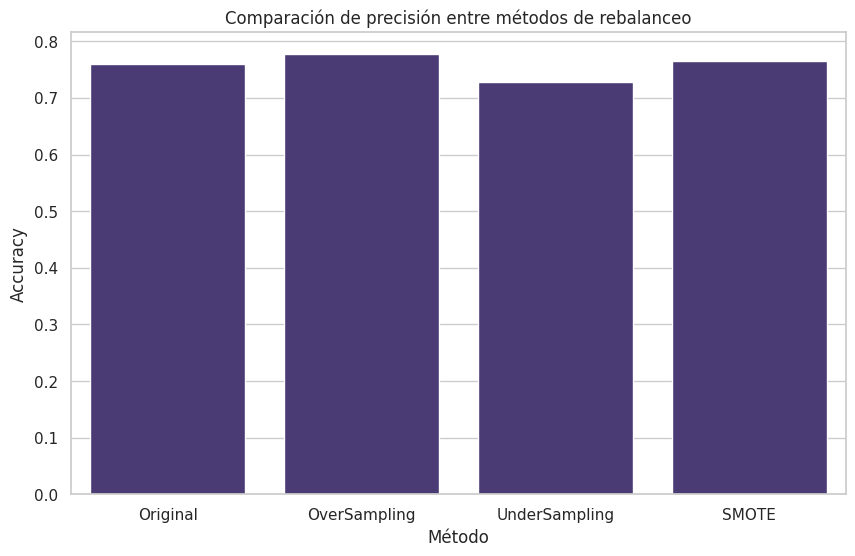

In [19]:
results_rf = pd.DataFrame({
    "Método": ["Original", "OverSampling", "UnderSampling", "SMOTE"],
    "Accuracy": [
        accuracy_score(y_test, RandomForestClassifier(random_state=42).fit(X_train, y_train).predict(X_test)),
        accuracy_score(y_test, y_pred_ros),
        accuracy_score(y_test, y_pred_rus),
        accuracy_score(y_test, y_pred_smote)
    ]
})
print(results_rf)
sns.barplot(x="Método", y="Accuracy", data=results_rf)
plt.title("Comparación de precisión entre métodos de rebalanceo")
plt.show()

## LOGISTIC REGRESSION

In [20]:
from sklearn.linear_model import LogisticRegression

**UnderSampling con Regresión Logística**

In [21]:
# OVERSAMPLING CON REGRESIÓN LOGÍSTICA
ros_lg = RandomOverSampler(random_state=42)
X_ros, y_ros = ros_lg.fit_resample(X_train, y_train)

print("Distribución después de Oversampling:")
print(y_ros.value_counts())

# Modelo de Regresión Logística
log_reg_ros = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs")
log_reg_ros.fit(X_ros, y_ros)
y_pred_ros = log_reg_ros.predict(X_test)

print("\n--- Logistic Regression con Oversampling ---")
print("Accuracy:", accuracy_score(y_test, y_pred_ros))
print(classification_report(y_test, y_pred_ros))

Distribución después de Oversampling:
target
0    1567
1    1567
2    1567
Name: count, dtype: int64

--- Logistic Regression con Oversampling ---
Accuracy: 0.7439759036144579
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       441
           1       0.85      0.81      0.83       642
           2       0.44      0.59      0.50       245

    accuracy                           0.74      1328
   macro avg       0.71      0.71      0.70      1328
weighted avg       0.77      0.74      0.75      1328



/home/neo/.envs/IronHack/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [22]:
## UnderSampling con Regresión Logística
rus_lg = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus_lg.fit_resample(X_train, y_train)

print("Distribución después de UnderSampling:")
print(y_rus.value_counts())

log_reg_rus = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs")
log_reg_rus.fit(X_rus, y_rus)
y_pred_rus = log_reg_rus.predict(X_test)

print("\n--- Logistic Regression con UnderSampling ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rus))
print(classification_report(y_test, y_pred_rus))

Distribución después de UnderSampling:
target
0    549
1    549
2    549
Name: count, dtype: int64

--- Logistic Regression con UnderSampling ---
Accuracy: 0.7394578313253012
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       441
           1       0.85      0.81      0.83       642
           2       0.42      0.58      0.48       245

    accuracy                           0.74      1328
   macro avg       0.71      0.70      0.70      1328
weighted avg       0.77      0.74      0.75      1328



/home/neo/.envs/IronHack/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


**SMOTE con Regresión Logística**

In [23]:
## SMOTE con Regresión Logística
smote_lg = SMOTE(random_state=42)
X_smote, y_smote = smote_lg.fit_resample(X_train, y_train)

print("Distribución después de SMOTE:")
print(y_smote.value_counts())

log_reg_smote = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs")
log_reg_smote.fit(X_smote, y_smote)
y_pred_smote = log_reg_smote.predict(X_test)

print("\n--- Logistic Regression con SMOTE ---")
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))

Distribución después de SMOTE:
target
0    1567
1    1567
2    1567
Name: count, dtype: int64

--- Logistic Regression con SMOTE ---
Accuracy: 0.7417168674698795
              precision    recall  f1-score   support

           0       0.83      0.74      0.79       441
           1       0.85      0.81      0.83       642
           2       0.43      0.57      0.49       245

    accuracy                           0.74      1328
   macro avg       0.70      0.71      0.70      1328
weighted avg       0.77      0.74      0.75      1328



/home/neo/.envs/IronHack/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


**Results**

/home/neo/.envs/IronHack/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


          Método  Accuracy
0       Original  0.759036
1   Oversampling  0.743976
2  Undersampling  0.739458
3          SMOTE  0.741717


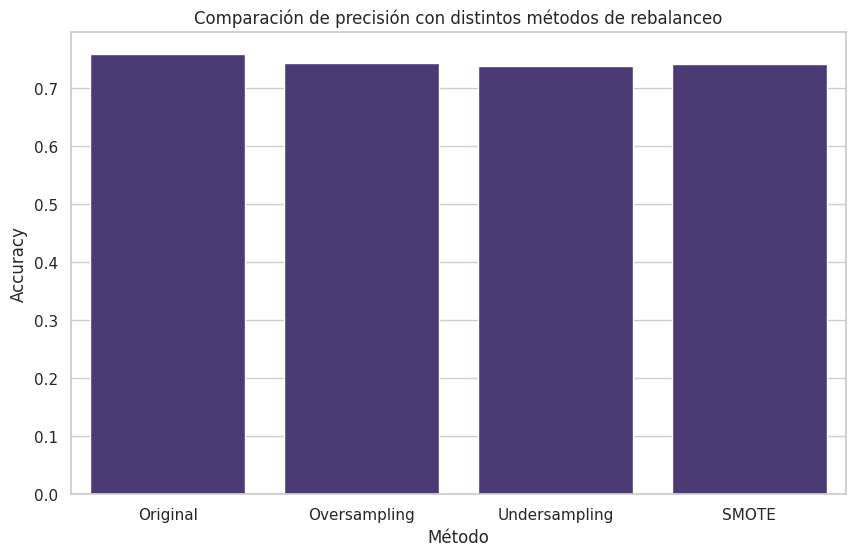

In [24]:
results_lg = pd.DataFrame({
    "Método": ["Original", "Oversampling", "Undersampling", "SMOTE"],
    "Accuracy": [
        accuracy_score(y_test, LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs").fit(X_train, y_train).predict(X_test)),
        accuracy_score(y_test, y_pred_ros),
        accuracy_score(y_test, y_pred_rus),
        accuracy_score(y_test, y_pred_smote)
    ]
})

print(results_lg)
sns.barplot(x="Método", y="Accuracy", data=results_lg)
plt.title("Comparación de precisión con distintos métodos de rebalanceo")
plt.show()


## XGBOOST

In [25]:
!pip install xgboost
import xgboost

In [26]:
from xgboost import XGBClassifier

**Oversampling con XGBoost**

In [27]:
## Oversampling con XGBoost
ros_xg = RandomOverSampler(random_state=42)
X_ros, y_ros = ros_xg.fit_resample(X_train, y_train)

print("\nDistribución tras Oversampling:")
print(y_ros.value_counts())

xgb_ros = XGBClassifier(
    objective="multi:softmax",
    num_class=len(y.unique()),
    eval_metric="mlogloss",
    random_state=42,
    use_label_encoder=False
)
xgb_ros.fit(X_ros, y_ros)
y_pred_ros = xgb_ros.predict(X_test)

print("\n--- XGBoost con Random OverSampling ---")
print("Accuracy:", accuracy_score(y_test, y_pred_ros))
print(classification_report(y_test, y_pred_ros))



Distribución tras Oversampling:
target
0    1567
1    1567
2    1567
Name: count, dtype: int64


/home/neo/.envs/IronHack/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [17:56:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost con Random OverSampling ---
Accuracy: 0.759789156626506
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       441
           1       0.80      0.88      0.84       642
           2       0.52      0.47      0.49       245

    accuracy                           0.76      1328
   macro avg       0.71      0.70      0.70      1328
weighted avg       0.76      0.76      0.76      1328



**UnderSampling con XGBoost**

In [28]:
##underSampling con XGBoost
rus_xg = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus_xg.fit_resample(X_train, y_train)

print("\nDistribución tras UnderSampling:")
print(y_rus.value_counts())

xgb_rus = XGBClassifier(
    objective="multi:softmax",
    num_class=len(y.unique()),
    eval_metric="mlogloss",
    random_state=42,
    use_label_encoder=False
)
xgb_rus.fit(X_rus, y_rus)
y_pred_rus = xgb_rus.predict(X_test)

print("\n--- XGBoost con Random UnderSampling ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rus))
print(classification_report(y_test, y_pred_rus))



Distribución tras UnderSampling:
target
0    549
1    549
2    549
Name: count, dtype: int64


/home/neo/.envs/IronHack/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [17:56:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost con Random UnderSampling ---
Accuracy: 0.7213855421686747
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       441
           1       0.83      0.77      0.80       642
           2       0.43      0.62      0.51       245

    accuracy                           0.72      1328
   macro avg       0.70      0.70      0.69      1328
weighted avg       0.76      0.72      0.73      1328



**SMOTE con XGBoost**

In [29]:
##SMOTE con XGBoost
smote_xg = SMOTE(random_state=42)
X_smote, y_smote = smote_xg.fit_resample(X_train, y_train)

print("\nDistribución tras SMOTE:")
print(y_smote.value_counts())

xgb_smote = XGBClassifier(
    objective="multi:softmax",
    num_class=len(y.unique()),
    eval_metric="mlogloss",
    random_state=42,
    use_label_encoder=False
)
xgb_smote.fit(X_smote, y_smote)
y_pred_smote = xgb_smote.predict(X_test)

print("\n--- XGBoost con SMOTE ---")
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))

### # Guardar el modelo
joblib.dump(xgb_smote, "../app/model/modelo_entrenado.sav")


Distribución tras SMOTE:
target
0    1567
1    1567
2    1567
Name: count, dtype: int64


/home/neo/.envs/IronHack/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [17:56:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost con SMOTE ---
Accuracy: 0.7658132530120482
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       441
           1       0.80      0.90      0.85       642
           2       0.53      0.42      0.47       245

    accuracy                           0.77      1328
   macro avg       0.72      0.69      0.70      1328
weighted avg       0.76      0.77      0.76      1328



['../app/model/modelo_entrenado.sav']

**Comparación entre los modelos: originales, Oversampling, Undersamplig y Smote**

/home/neo/.envs/IronHack/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [17:56:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Comparación de resultados:
          Método  Accuracy
0       Original  0.765060
1   Oversampling  0.759789
2  Undersampling  0.721386
3          SMOTE  0.765813


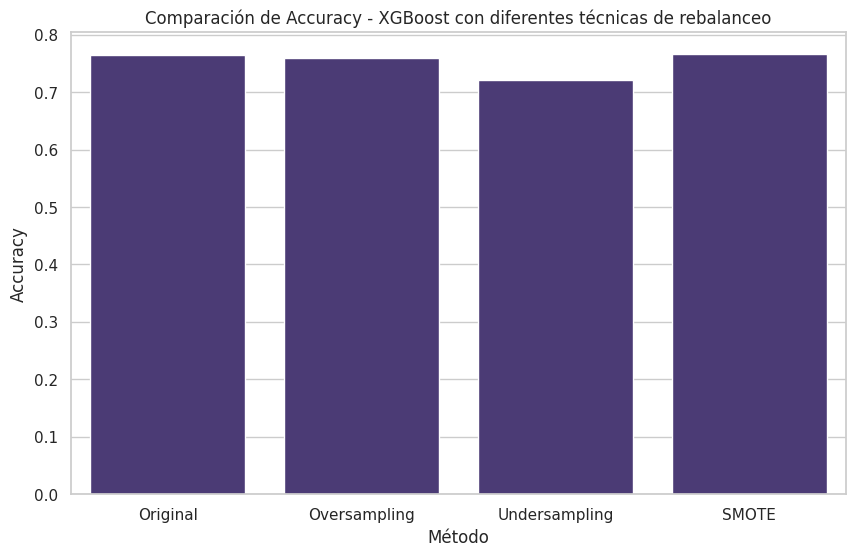

In [30]:
results_xg = pd.DataFrame({
    "Método": ["Original", "Oversampling", "Undersampling", "SMOTE"],
    "Accuracy": [
        accuracy_score(y_test, XGBClassifier(objective="multi:softmax", num_class=len(y.unique()), eval_metric="mlogloss", random_state=42, use_label_encoder=False).fit(X_train, y_train).predict(X_test)),
        accuracy_score(y_test, y_pred_ros),
        accuracy_score(y_test, y_pred_rus),
        accuracy_score(y_test, y_pred_smote)
    ]
})

print("\nComparación de resultados:")
print(results_xg)
sns.barplot(x="Método", y="Accuracy", data=results_xg)
plt.title("Comparación de Accuracy - XGBoost con diferentes técnicas de rebalanceo")
plt.show()

**Power Bi**

/tmp/ipykernel_11352/2191723020.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=marital_counts_mapped.index, y=marital_counts_mapped.values, ax=axes[0, 1], palette='tab10')
/tmp/ipykernel_11352/2191723020.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='Curricular units 1st sem (grade)', data=df, ax=axes[1, 0], palette='coolwarm')
/tmp/ipykernel_11352/2191723020.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='Unemployment rate', data=df, ax=axes[1, 1], palette='plasma')


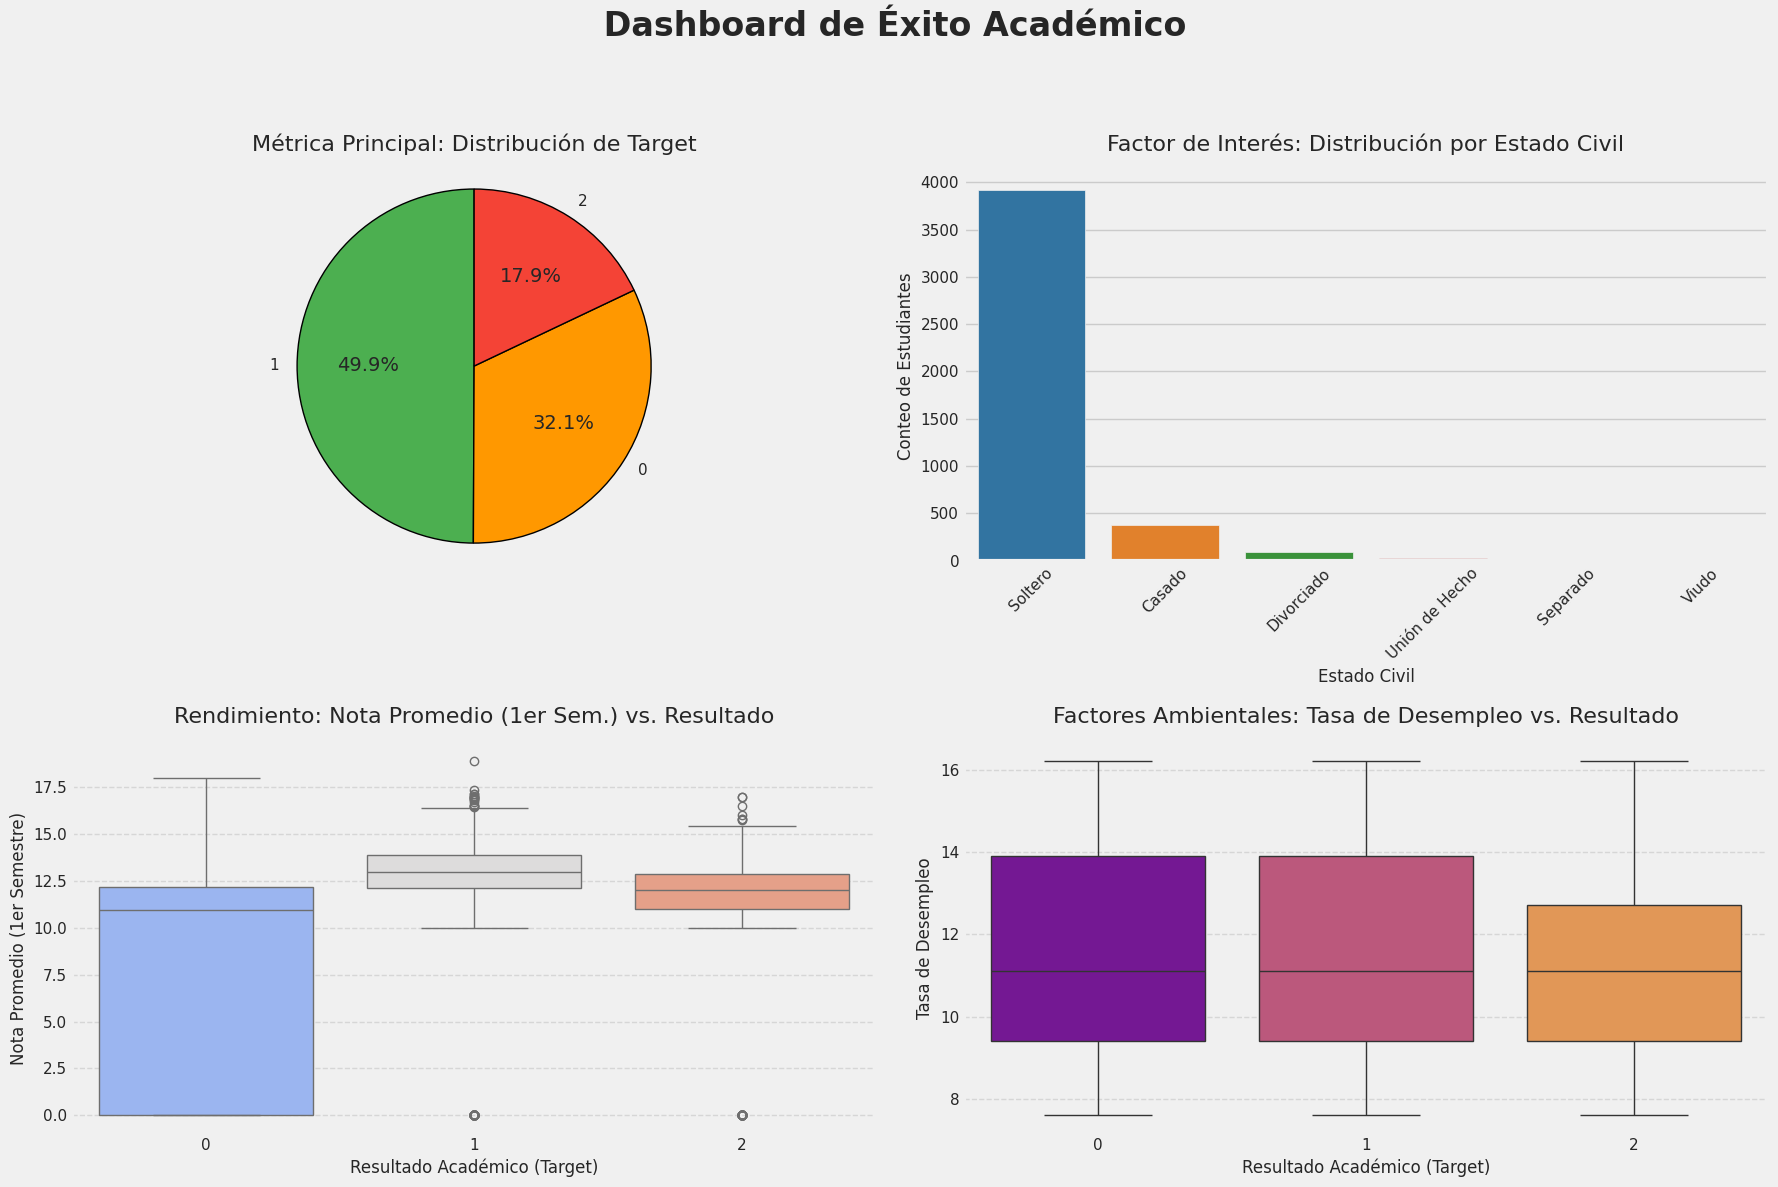

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del estilo para simular un dashboard moderno
plt.style.use('fivethirtyeight')

# --- 1. Preparación de Datos ---

# Métrica Principal: Distribución de la Variable 'target'
target_counts = df['target'].value_counts()

# NUEVO FACTOR DE INTERÉS: Distribución del Estado Civil (Marital Status)
# Analizaremos la distribución de estudiantes según su estado civil al momento de la matrícula.
marital_counts = df['Marital Status'].value_counts()
# Es común que los códigos deban ser mapeados a nombres para una mejor comprensión en el dashboard.
# Mapeo de ejemplo (basado en datasets similares, pero los códigos reales podrían variar):
marital_map = {1: 'Soltero', 2: 'Casado', 3: 'Viudo', 4: 'Divorciado', 5: 'Unión de Hecho', 6: 'Separado'}
df['Marital Status Description'] = df['Marital Status'].map(marital_map).fillna('Otro')
marital_counts_mapped = df['Marital Status Description'].value_counts()

# --- 2. Creación del Dashboard ---

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(' Dashboard de Éxito Académico', fontsize=24, fontweight='bold', y=1.02)
plt.subplots_adjust(hspace=0.4)

# 1. Gráfico de Anillo/Tarta: Distribución de la Variable 'target' (Métrica Principal)
colors_target = ['#4CAF50', '#FF9800', '#F44336']
wedge, text, autotext = axes[0, 0].pie(target_counts,
                                       labels=target_counts.index,
                                       autopct='%1.1f%%',
                                       startangle=90,
                                       colors=colors_target,
                                       wedgeprops={'edgecolor': 'black', 'linewidth': 1})
axes[0, 0].set_title('Métrica Principal: Distribución de Target', fontsize=16, pad=15)
axes[0, 0].axis('equal')

# 2. Gráfico de Barras: Distribución del Estado Civil (NUEVO FACTOR)
# Usaremos un gráfico de barras simple para mostrar el conteo por estado civil
sns.barplot(x=marital_counts_mapped.index, y=marital_counts_mapped.values, ax=axes[0, 1], palette='tab10')
axes[0, 1].set_title('Factor de Interés: Distribución por Estado Civil', fontsize=16, pad=15)
axes[0, 1].set_xlabel('Estado Civil', fontsize=12)
axes[0, 1].set_ylabel('Conteo de Estudiantes', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45) # Rota las etiquetas para mejor legibilidad

# 3. Gráfico de Cajas: Nota Promedio (1er Semestre) vs. 'target' (Rendimiento)
sns.boxplot(x='target', y='Curricular units 1st sem (grade)', data=df, ax=axes[1, 0], palette='coolwarm')
axes[1, 0].set_title('Rendimiento: Nota Promedio (1er Sem.) vs. Resultado', fontsize=16, pad=15)
axes[1, 0].set_xlabel('Resultado Académico (Target)', fontsize=12)
axes[1, 0].set_ylabel('Nota Promedio (1er Semestre)', fontsize=12)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# 4. Gráfico de Cajas: Tasa de Desempleo vs. 'target' (Factores Ambientales)
sns.boxplot(x='target', y='Unemployment rate', data=df, ax=axes[1, 1], palette='plasma')
axes[1, 1].set_title('Factores Ambientales: Tasa de Desempleo vs. Resultado', fontsize=16, pad=15)
axes[1, 1].set_xlabel('Resultado Académico (Target)', fontsize=12)
axes[1, 1].set_ylabel('Tasa de Desempleo', fontsize=12)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()